# St Ebbes reference data work flow to support aggregations by COVID restriction data

## Imports

In [3]:
# Imports
#---------
import pandas as pd
import os
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib as mpl
import statsmodels.api as sm

aurn_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/aurn/aurn_2016_2021/'
stats_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/gap_filling/536_method/lockdown_stats/'


## Load reference data
1-hour reference data for Oxford AURN & AQE stations obtained from Ricardo R data store. See also;

`/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/aurn/data_for_ajit/get_1hour_ox_auto_data.ipynb`

Using 6-years data 2016 to 2021 to estimate average conditions over this period. Reasoning for 6 years being, 2016 had low data capture & 2021 forms part of the study year.

Index(['OX', 'OX8', 'OX3', 'OX6'], dtype='object', name='code')

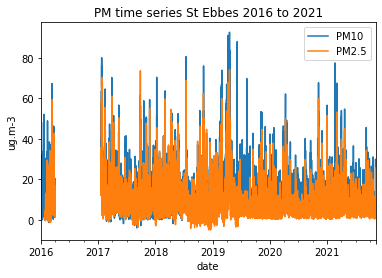

In [4]:
# Load 1-hour data 2016 to 2021
#-------------------------------

oxford_auto_20162021_1hr = pd.read_csv(aurn_home+'oxford_auto_20162021_1hr.csv.gz')#, index_col='date')
oxford_auto_20162021_1hr['date'] = pd.to_datetime(oxford_auto_20162021_1hr['date'], utc=True)
oxford_auto_20162021_1hr.set_index(['date','code','site'], inplace=True)
display(oxford_auto_20162021_1hr.index.get_level_values(1).unique())

oxford_auto_20162021_1hr.query('code == "OX8"').sort_index().reset_index().plot(x='date', 
                                                                                y=['PM10','PM2.5'], 
                                                                                title='PM time series St Ebbes 2016 to 2021',
                                                                                ylabel='ug.m-3')
plt.show()

oxford_auto_20162021_1hr

## Reorganising the dataframe & aggregating
1-hour data reduced to St Ebbes & O2, PM10 & PM2.5 only. Data then grouped by the day of year, binning all 1-hour data across 6 years togther by ordinal day, then calculating descriptive statistics on these binned data. Key descriptive stats being the mean (of 1-hour observations) each day (daily mean) & the 99th percentile of hourly means each day.

These stats provide an indicator of the variation in typical & extreme concentrations influenced local conditions each day throughout the pandemic. In a later step we group & aggregate these descriptive stats further by restriction event to show temporal variations that will be influenced by the event(s) & meterologocal conditions.

In [3]:
# Housekeeping & aggregation
#-----------------------------
start16 = pd.to_datetime('2016-01-01', utc=True)
end19 = pd.to_datetime('2020-01-01', utc=True)

# Constrained to sebbes only
sebbes1619 = oxford_auto_20162021_1hr.query('code == "OX8" and @start16 <= date < @end19')
# Constrain to no2, pm10 & pm2.5
sebbes = sebbes1619[['NO2','PM10','PM2.5']].reset_index(['code','site'])   #.resample('1D', closed = 'right').mean()
# aggregate by ordinal day
sebbes_ordinal_daymean = sebbes.groupby(sebbes.index.dayofyear).describe(percentiles=[0.99])

# df = oxaria_pm[['val.pm10_1_c2_SH_xt_cor','val.pm2p5_1_c2_S_xt_cor']].groupby([pd.Grouper(level='fname'),
#                                                                                pd.Grouper(level='rec', freq='24H')]
#                                                                              ).describe(percentiles=[0.99])

# Sort index
s1 = sebbes_ordinal_daymean.iloc[:,[0,1,2,3,4,5,6]].add_prefix('no2_').columns.droplevel()
s2 = sebbes_ordinal_daymean.iloc[:,[7,8,9,10,11,12,13]].add_prefix('pm10_').columns.droplevel()
s3 = sebbes_ordinal_daymean.iloc[:,[14,15,16,17,18,19,20]].add_prefix('pm25_').columns.droplevel()
new_cols = list(s1.append([s2, s3]))
sebbes_ordinal_daymean.columns = new_cols

sebbes_ordinal_daymean


,no2_count,no2_mean,no2_std,no2_min,no2_50%,no2_99%,no2_max,pm10_count,pm10_mean,pm10_std,...,pm10_50%,pm10_99%,pm10_max,pm25_count,pm25_mean,pm25_std,pm25_min,pm25_50%,pm25_99%,pm25_max
date,,,,,,,,,,,,,,,,,,,,,
1,95.0,9.714886,7.107912,0.77839,7.984090,26.934535,27.57428,48.0,7.918750,3.466782,...,7.1500,15.95300,16.000,47.0,4.642553,2.464949,0.5,4.4000,9.86200,10.000
2,95.0,18.740614,13.187118,2.34852,14.225880,48.934169,50.28618,48.0,11.727083,8.469890,...,9.3500,37.91900,39.000,42.0,5.450000,3.815389,-2.9,4.8500,15.78800,17.100
3,91.0,15.387964,12.359264,0.89314,10.545040,49.713973,49.91596,36.0,14.255556,10.552060,...,12.5000,33.98500,34.300,12.0,3.708333,2.325143,0.1,3.2000,7.56800,7.700
4,94.0,23.167618,15.275358,1.29638,20.003405,56.003654,59.81392,23.0,10.217391,8.269915,...,6.4000,29.25600,29.300,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,90.0,31.280543,19.111326,3.03265,28.012490,75.108354,77.39601,12.0,7.666667,3.576523,...,7.4000,14.46000,14.900,11.0,9.736364,7.576975,1.1,6.0000,20.08000,20.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,72.0,18.823513,9.514374,4.44206,17.938505,44.583604,45.12904,72.0,12.872569,7.567904,...,10.0000,29.21900,30.000,54.0,13.098630,6.715243,0.1,11.1000,30.13600,34.800
363,71.0,12.624569,9.244557,2.51050,8.543510,33.845678,36.30559,72.0,10.955903,4.905644,...,11.2875,21.51800,24.500,68.0,8.667926,4.658593,-0.9,9.0135,18.13100,18.600
364,72.0,12.610021,9.638462,0.87935,9.465195,36.322675,38.03736,72.0,15.638542,9.097126,...,13.5125,36.14500,36.500,70.0,10.663543,5.930981,-0.7,10.9600,26.09138,32.300


In [1]:
oxford_auto_20162021_1hr

NameError: name 'oxford_auto_20162021_1hr' is not defined

## Choosing metrics to demonstrate change
The graphs below demonstrate the pros & cons of 3 methods / metrics that could be used to demonstrate deviation from typical levels already experienced 2016-2021. Using the standard daily mean is shown to be potentially problematic because of the variation in the statistic throughout the year. As alternative we present 2 different initialisations LOWESS regression smoothing method which applies Locally Weighted Scatterplot Smoothing to smooth the peak in the standard daily mean, plus a rolling 28-day mean.

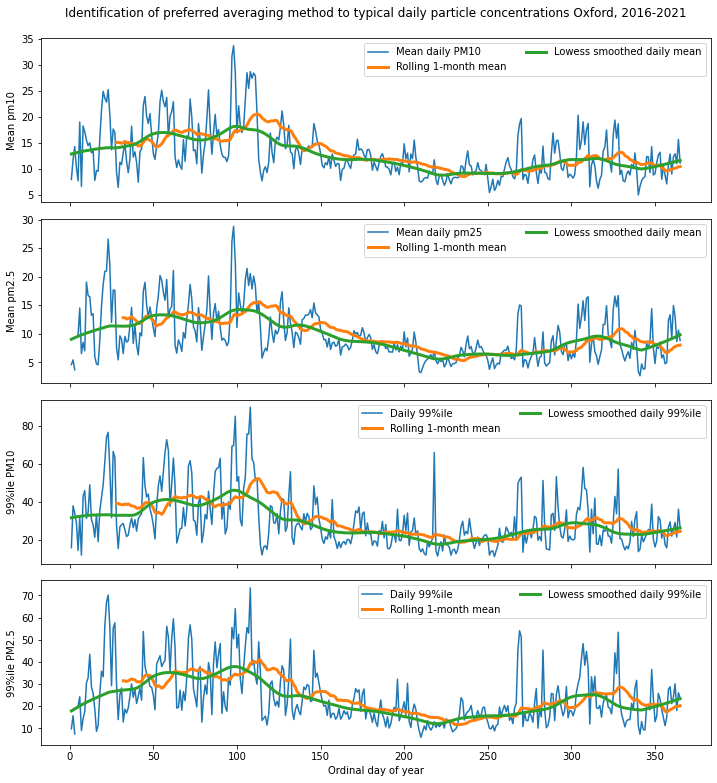

In [4]:
# Compare approaches to calculating mean dailt PM10 values by ordinal day
#-------------------------------------------------------------------------

# Doing PM10
#------------
figure, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12,13), sharex=True)

sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm10_mean', ax=ax1, label='Mean daily PM10', lw=1.5)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28).mean(), 
             x=sebbes_ordinal_daymean.index, y='pm10_mean', ax=ax1, label='Rolling 1-month mean', lw=3)

# smoothed_m1 = pd.DataFrame(sm.nonparametric.lowess
#                            (exog=sebbes_ordinal_daymean.index, endog=sebbes_ordinal_daymean['pm10_mean'], frac=0.3, it=1),  columns=['x','y10'])
smoothed_m2 = pd.DataFrame(sm.nonparametric.lowess
                           (exog=sebbes_ordinal_daymean.index, endog=sebbes_ordinal_daymean['pm10_mean'], frac=0.13, it=1),  columns=['x','y10'])

sns.lineplot(data=smoothed_m2, x='x', y='y10', ax=ax1, label='Lowess smoothed daily mean', lw=3)
#sns.lineplot(data=smoothed_m1, x='x', y='y10', ax=ax1, label='Lowess best-fit frac=0.30', lw=3)

sebbes_ordinal_daymean = sebbes_ordinal_daymean.reset_index().merge(smoothed_m2, left_on='date', right_on='x', how='left').drop('x',axis=1).set_index(['date'])

# Doing PM2.5
#-------------
sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm25_mean', ax=ax2, label='Mean daily pm25', lw=1.5)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28).mean(), x=sebbes_ordinal_daymean.index, y='pm25_mean', ax=ax2, label='Rolling 1-month mean', lw=3)

# smoothed_m1 = pd.DataFrame(sm.nonparametric.lowess(exog=sebbes_ordinal_daymean.index, endog=sebbes_ordinal_daymean['pm25_mean'], frac=0.3, it=1),  columns=['x','y25'])
smoothed_m2 = pd.DataFrame(sm.nonparametric.lowess(exog=sebbes_ordinal_daymean.index, endog=sebbes_ordinal_daymean['pm25_mean'], frac=0.13, it=1),  columns=['x','y25'])

sns.lineplot(data=smoothed_m2, x='x', y='y25', ax=ax2, label='Lowess smoothed daily mean', lw=3)
#sns.lineplot(data=smoothed_m1, x='x', y='y25', ax=ax2, label='Lowess best-fit frac=0.30', lw=3)

sebbes_ordinal_daymean = sebbes_ordinal_daymean.reset_index().merge(smoothed_m2, left_on='date', right_on='x', how='left').drop('x',axis=1).set_index(['date'])

# Doing PM10, 99%ile
#--------------------
sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm10_99%', ax=ax3, label='Daily 99%ile', lw=1.5)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28).mean(), x=sebbes_ordinal_daymean.index, y='pm10_99%', ax=ax3, label='Rolling 1-month mean', lw=3)

#smoothed_m1 = pd.DataFrame(sm.nonparametric.lowess(exog=sebbes_ordinal_daymean.index, endog=sebbes_ordinal_daymean['pm10_99%'], frac=0.3, it=1),  columns=['x','ypm1099'])
smoothed_m2 = pd.DataFrame(sm.nonparametric.lowess(exog=sebbes_ordinal_daymean.index, endog=sebbes_ordinal_daymean['pm10_99%'], frac=0.13, it=1),  columns=['x','ypm1099'])

sns.lineplot(data=smoothed_m2, x='x', y='ypm1099', ax=ax3, label='Lowess smoothed daily 99%ile', lw=3)
#sns.lineplot(data=smoothed_m1, x='x', y='ypm1099', ax=ax3, label='Lowess best-fit frac=0.30', lw=3)

sebbes_ordinal_daymean = sebbes_ordinal_daymean.reset_index().merge(smoothed_m2, left_on='date', right_on='x', how='left').drop('x',axis=1).set_index(['date'])

# Doing PM2.5, 99%ile
#---------------------
sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm25_99%', ax=ax4, label='Daily 99%ile', lw=1.5)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28).mean(), x=sebbes_ordinal_daymean.index, y='pm25_99%', ax=ax4, label='Rolling 1-month mean', lw=3)

# smoothed_m1 = pd.DataFrame(sm.nonparametric.lowess(exog=sebbes_ordinal_daymean.index, endog=sebbes_ordinal_daymean['pm25_99%'], frac=0.3, it=1),  columns=['x','ypm2599'])
smoothed_m2 = pd.DataFrame(sm.nonparametric.lowess(exog=sebbes_ordinal_daymean.index, endog=sebbes_ordinal_daymean['pm25_99%'], frac=0.13, it=1),  columns=['x','ypm2599'])

sns.lineplot(data=smoothed_m2, x='x', y='ypm2599', ax=ax4, label='Lowess smoothed daily 99%ile', lw=3)
#sns.lineplot(data=smoothed_m1, x='x', y='ypm2599', ax=ax4, label='Lowess best-fit frac=0.30', lw=3)

sebbes_ordinal_daymean = sebbes_ordinal_daymean.reset_index().merge(smoothed_m2, left_on='date', right_on='x', how='left').drop('x',axis=1).set_index(['date'])

ax1.set(xlabel='', ylabel = 'Mean pm10', title='Identification of preferred averaging method to typical daily particle concentrations Oxford, 2016-2021\n')
ax2.set(ylabel = 'Mean pm2.5')
ax3.set(ylabel = '99%ile PM10')
ax4.set(xlabel='Ordinal day of year', ylabel = '99%ile PM2.5')

ax1.legend(ncol=2, loc='upper right')
ax2.legend(ncol=2, loc='upper right')
ax3.legend(ncol=2, loc='upper right')
ax4.legend(ncol=2, loc='upper right')
plt.subplots_adjust(wspace=0.1, hspace=0.1)


plt.savefig(stats_home+'identifying_averging_methods_1619.png')

plt.show()


In [5]:
sebbes_ordinal_daymean.reset_index().to_feather(stats_home+'sebbes_ordinal_daymean_aggregates_2016_2019.ftr') 
sebbes_ordinal_daymean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 1 to 366
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   no2_count   366 non-null    float64
 1   no2_mean    365 non-null    float64
 2   no2_std     365 non-null    float64
 3   no2_min     365 non-null    float64
 4   no2_50%     365 non-null    float64
 5   no2_99%     365 non-null    float64
 6   no2_max     365 non-null    float64
 7   pm10_count  366 non-null    float64
 8   pm10_mean   365 non-null    float64
 9   pm10_std    365 non-null    float64
 10  pm10_min    365 non-null    float64
 11  pm10_50%    365 non-null    float64
 12  pm10_99%    365 non-null    float64
 13  pm10_max    365 non-null    float64
 14  pm25_count  366 non-null    float64
 15  pm25_mean   364 non-null    float64
 16  pm25_std    364 non-null    float64
 17  pm25_min    364 non-null    float64
 18  pm25_50%    364 non-null    float64
 19  pm25_99%    364 non-null    f

In [6]:
sebbes_ordinal_daymean.head()

,no2_count,no2_mean,no2_std,no2_min,no2_50%,no2_99%,no2_max,pm10_count,pm10_mean,pm10_std,...,pm25_mean,pm25_std,pm25_min,pm25_50%,pm25_99%,pm25_max,y10,y25,ypm1099,ypm2599
date,,,,,,,,,,,,,,,,,,,,,
1,95.0,9.714886,7.107912,0.77839,7.984090,26.934535,27.57428,48.0,7.918750,3.466782,...,4.642553,2.464949,0.5,4.40,9.862,10.0,12.845797,9.063850,31.643229,17.901039
2,95.0,18.740614,13.187118,2.34852,14.225880,48.934169,50.28618,48.0,11.727083,8.469890,...,5.450000,3.815389,-2.9,4.85,15.788,17.1,12.929446,9.203194,31.815303,18.381648
3,91.0,15.387964,12.359264,0.89314,10.545040,49.713973,49.91596,36.0,14.255556,10.552060,...,3.708333,2.325143,0.1,3.20,7.568,7.7,13.009806,9.337289,31.977368,18.850057
4,94.0,23.167618,15.275358,1.29638,20.003405,56.003654,59.81392,23.0,10.217391,8.269915,...,NaN,NaN,NaN,NaN,NaN,NaN,13.086911,NaN,32.129081,NaN
5,90.0,31.280543,19.111326,3.03265,28.012490,75.108354,77.39601,12.0,7.666667,3.576523,...,9.736364,7.576975,1.1,6.00,20.080,20.1,13.160791,9.590179,32.269987,19.749830


## Define some functions to code up the ordinal days for by lockdown events
Have to do this in 2 hits because we have events that cover 2 years & data linked to ordinal / year agnostic days

In [7]:
def lockdown_codeup_ondate(df):
    df1 = df.reset_index().assign(ld_code=lambda x: x['rec'].apply(
        lambda y: 'a' if y < pd.to_datetime('2020-03-23', utc=True) else         # normal times
        ('b' if y < pd.to_datetime('2020-05-10', utc=True) else                   # lockdown 1
         ('c' if y < pd.to_datetime('2020-09-24', utc=True) else                   # easing 1-3 
          ('d' if y < pd.to_datetime('2020-11-05', utc=True) else                   # tier 1-2
           ('e' if y < pd.to_datetime('2020-12-02', utc=True) else                   # lockdown 2
            ('f' if y < pd.to_datetime('2021-01-05', utc=True) else                   # tier 4-2
             ('g' if y < pd.to_datetime('2021-03-08', utc=True) else                   # lockdown 3
              ('h' if y < pd.to_datetime('2021-04-12', utc=True) else                   # step 1
               ('i' if y < pd.to_datetime('2021-05-17', utc=True) else                   # step 2
                ('j' if y < pd.to_datetime('2021-06-21', utc=True) else 'k'               # step 3 else 17 # step 4
                )))))))))))
    return df1

def lockdown_codeup_onordinal_af(df):
    df1 = df.reset_index().assign(ld_code=lambda x: x['date'].apply(
        lambda y: 'a' if y < pd.to_datetime('2020-03-23', utc=True).dayofyear else         # normal times
        ('b' if y < pd.to_datetime('2020-05-10', utc=True).dayofyear else                    # lockdown 1
         ('c' if y < pd.to_datetime('2020-09-24', utc=True).dayofyear else                    # easing 1-3 
          ('d' if y < pd.to_datetime('2020-11-05', utc=True).dayofyear else                    # tier 1-2
           ('e' if y < pd.to_datetime('2020-12-02', utc=True).dayofyear else 'f'                # lockdown 2
             ))))))
    return df1                  
                  
def lockdown_codeup_onordinal_fk(df):
    df2 = df.reset_index().assign(ld_code=lambda x: x['date'].apply(
        lambda y: 'f' if y < pd.to_datetime('2021-01-05', utc=True).dayofyear else           # tier 4-2
        ('g' if y < pd.to_datetime('2021-03-08', utc=True).dayofyear else                    # lockdown 3
         ('h' if y < pd.to_datetime('2021-04-12', utc=True).dayofyear else                    # step1
          ('i' if y < pd.to_datetime('2021-05-17', utc=True).dayofyear else                    # step2
           ('j' if y < pd.to_datetime('2021-06-21', utc=True).dayofyear else  'k'               # step 3 else 17 # step 4
           ))))))
    return df2


In [8]:
# Code up the sensor data with lockdown codes by 'rec'
#------------------------------------------------------
sebbes_ordinal_daymean = pd.read_feather(stats_home+'sebbes_ordinal_daymean_aggregates_2016_2019.ftr')
sebbes_ordinal_daymean_codeup_af = lockdown_codeup_onordinal_af(sebbes_ordinal_daymean)
sebbes_ordinal_daymean_codeup_af['ld_code'].unique()

array(['a', 'b', 'c', 'd', 'e', 'f'], dtype=object)

In [9]:
# Code up the sensor data with lockdown codes by 'rec'
#------------------------------------------------------
sebbes_ordinal_daymean = pd.read_feather(stats_home+'sebbes_ordinal_daymean_aggregates_2016_2019.ftr')
sebbes_ordinal_daymean_codeup_fk = lockdown_codeup_onordinal_fk(sebbes_ordinal_daymean)
sebbes_ordinal_daymean_codeup_fk['ld_code'].unique()

array(['f', 'g', 'h', 'i', 'j', 'k'], dtype=object)

In [10]:
sebbes_ordinal_daymean_codeup_af.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       366 non-null    int64  
 1   date        366 non-null    int64  
 2   no2_count   366 non-null    float64
 3   no2_mean    365 non-null    float64
 4   no2_std     365 non-null    float64
 5   no2_min     365 non-null    float64
 6   no2_50%     365 non-null    float64
 7   no2_99%     365 non-null    float64
 8   no2_max     365 non-null    float64
 9   pm10_count  366 non-null    float64
 10  pm10_mean   365 non-null    float64
 11  pm10_std    365 non-null    float64
 12  pm10_min    365 non-null    float64
 13  pm10_50%    365 non-null    float64
 14  pm10_99%    365 non-null    float64
 15  pm10_max    365 non-null    float64
 16  pm25_count  366 non-null    float64
 17  pm25_mean   364 non-null    float64
 18  pm25_std    364 non-null    float64
 19  pm25_min    364 non-null    f

In [11]:
sebbes_ordinal_daymean_codeup_fk#.info()

,index,date,no2_count,no2_mean,no2_std,no2_min,no2_50%,no2_99%,no2_max,pm10_count,...,pm25_std,pm25_min,pm25_50%,pm25_99%,pm25_max,y10,y25,ypm1099,ypm2599,ld_code
0,0,1,95.0,9.714886,7.107912,0.77839,7.984090,26.934535,27.57428,48.0,...,2.464949,0.5,4.4000,9.86200,10.000,12.845797,9.063850,31.643229,17.901039,f
1,1,2,95.0,18.740614,13.187118,2.34852,14.225880,48.934169,50.28618,48.0,...,3.815389,-2.9,4.8500,15.78800,17.100,12.929446,9.203194,31.815303,18.381648,f
2,2,3,91.0,15.387964,12.359264,0.89314,10.545040,49.713973,49.91596,36.0,...,2.325143,0.1,3.2000,7.56800,7.700,13.009806,9.337289,31.977368,18.850057,f
3,3,4,94.0,23.167618,15.275358,1.29638,20.003405,56.003654,59.81392,23.0,...,NaN,NaN,NaN,NaN,NaN,13.086911,NaN,32.129081,NaN,f
4,4,5,90.0,31.280543,19.111326,3.03265,28.012490,75.108354,77.39601,12.0,...,7.576975,1.1,6.0000,20.08000,20.100,13.160791,9.590179,32.269987,19.749830,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,361,362,72.0,18.823513,9.514374,4.44206,17.938505,44.583604,45.12904,72.0,...,6.715243,0.1,11.1000,30.13600,34.800,11.347914,9.438987,25.798101,22.666048,k
362,362,363,71.0,12.624569,9.244557,2.51050,8.543510,33.845678,36.30559,72.0,...,4.658593,-0.9,9.0135,18.13100,18.600,11.431732,9.577806,25.962379,22.919471,k
363,363,364,72.0,12.610021,9.638462,0.87935,9.465195,36.322675,38.03736,72.0,...,5.930981,-0.7,10.9600,26.09138,32.300,11.516684,9.719287,26.128357,23.176235,k
364,364,365,72.0,10.698757,7.805231,0.16570,8.945575,24.452435,24.55542,72.0,...,7.028753,-1.0,7.5000,23.81268,26.651,11.602785,9.863211,26.296235,23.436181,k


## Stats logic

### Arithmetic mean
For each lockdown event, calculate descriptive stats for that event based on the daily mean PM concentration. 

### LOWESS mean 
For each lockdown event, calculate descriptive stats for that event based on the daily mean PM concentration estimate based on preferred LOWESS bestfit line.

### 99th percentile
Two options;
1. For each lockdown event, calculate the 99%ile of daily 99%ile PM concentrations (calculated from 1-hour concentrations).
2. For each lockdown event, calculate the average daily 99%ile PM concentration for that event based on the daily 99%ile PM concentrations (calculated from 1-hour concentrations).
3. For each lockdown event, calculate the 99%ile of daily mean PM concentrations (calculated from 1-hour concentrations).

I think we want option (2) for percentiles.

In [12]:
sebbes_ordinal_daymean_codeup_ak = pd.concat([sebbes_ordinal_daymean_codeup_af, sebbes_ordinal_daymean_codeup_fk.query('date <= 292')]).reset_index(drop=True)

In [13]:
sebbes_ordinal_daymean_codeup_ak.to_feather(stats_home+'sebbes_ordinal_daymean_codeup_ak_1619.ftr')
sebbes_ordinal_daymean_codeup_ak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       658 non-null    int64  
 1   date        658 non-null    int64  
 2   no2_count   658 non-null    float64
 3   no2_mean    657 non-null    float64
 4   no2_std     657 non-null    float64
 5   no2_min     657 non-null    float64
 6   no2_50%     657 non-null    float64
 7   no2_99%     657 non-null    float64
 8   no2_max     657 non-null    float64
 9   pm10_count  658 non-null    float64
 10  pm10_mean   657 non-null    float64
 11  pm10_std    657 non-null    float64
 12  pm10_min    657 non-null    float64
 13  pm10_50%    657 non-null    float64
 14  pm10_99%    657 non-null    float64
 15  pm10_max    657 non-null    float64
 16  pm25_count  658 non-null    float64
 17  pm25_mean   655 non-null    float64
 18  pm25_std    655 non-null    float64
 19  pm25_min    655 non-null    f

In [14]:
# pm10 arithemtic mean, events 'a' to 'k'
tmplist = []
for i, r in sebbes_ordinal_daymean_codeup_ak.groupby('ld_code'):
    tmp = r.groupby(['ld_code'])[['pm10_mean','pm10_50%','pm10_99%','pm10_max']].mean()
    tmplist.append(tmp)
sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10 = pd.concat(tmplist)
sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10['poll'] = 'pm10'                     
sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10.reset_index().to_feather(stats_home+'sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10_1619.ftr')

# pm2.5 arithemtic mean, events 'a' to 'k'
tmplist = []
for i, r in sebbes_ordinal_daymean_codeup_ak.groupby('ld_code'):
    tmp = r.groupby(['ld_code'])[['pm25_mean','pm25_50%','pm25_99%','pm25_max']].mean()
    tmplist.append(tmp)
sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25 = pd.concat(tmplist)
sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25['poll'] = 'pm25'
sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25.reset_index().to_feather(stats_home+'sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25_1619.ftr')

display(sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10, sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25)

,pm10_mean,pm10_50%,pm10_99%,pm10_max,poll
ld_code,,,,,
a,15.402617,13.170122,37.842793,40.697561,pm10
b,17.955003,15.030208,42.327167,44.177083,pm10
c,10.740171,9.978193,23.223077,25.660584,pm10
d,11.901237,10.117560,30.282690,32.595238,pm10
e,11.428570,10.551389,25.250704,27.542593,pm10
f,10.464658,9.207576,24.953659,26.765152,pm10
g,15.761528,13.481452,38.918258,41.988710,pm10
h,17.025160,14.560000,42.442657,45.254286,pm10
i,16.858084,14.121429,37.495029,38.500000,pm10


,pm25_mean,pm25_50%,pm25_99%,pm25_max,poll
ld_code,,,,,
a,12.349181,10.149383,31.314049,32.979012,pm25
b,13.682751,11.205208,34.089771,35.929167,pm25
c,7.834553,7.079577,17.621638,18.961044,pm25
d,8.330073,6.377464,24.267582,26.449119,pm25
e,9.327398,8.441611,23.135636,24.948630,pm25
f,7.701672,6.847859,19.370469,20.666438,pm25
g,12.870203,10.554032,32.374597,34.075806,pm25
h,13.164310,10.760000,34.786400,36.845714,pm25
i,12.835871,10.670000,30.555943,31.888571,pm25


In [15]:
# Calc descriptive stats by ld_code & assign them, to ordinal codes
#-----------------------------------------------------------------------

a = pd.to_datetime('2020-03-23', utc=True).dayofyear 
b = pd.to_datetime('2020-05-10', utc=True).dayofyear 
c = pd.to_datetime('2020-09-24', utc=True).dayofyear
d = pd.to_datetime('2020-11-05', utc=True).dayofyear
e = pd.to_datetime('2020-12-02', utc=True).dayofyear
f = pd.to_datetime('2021-01-05', utc=True).dayofyear
g = pd.to_datetime('2021-03-08', utc=True).dayofyear
h = pd.to_datetime('2021-04-12', utc=True).dayofyear
i = pd.to_datetime('2021-05-17', utc=True).dayofyear
j = pd.to_datetime('2021-06-21', utc=True).dayofyear
k = pd.to_datetime('2021-07-01', utc=True).dayofyear

ord_list = [a,b,c,d,e,f,g,h,i,j,k]

# pm10 arithemtic mean, events 'a' to 'k'
tmplist = []
for i, r in sebbes_ordinal_daymean_codeup_ak.groupby('ld_code'):
    tmp = r.groupby(['ld_code'])[['pm10_mean','pm10_50%','pm10_99%','pm10_max']].describe()
    tmplist.append(tmp)
test_sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10 = pd.concat(tmplist)
test_sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10['poll'] = 'pm10'
#sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10.reset_index().to_feather(stats_home+'sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10.ftr')

# pm2.5 arithemtic mean, events 'a' to 'k'
tmplist = []
for i, r in sebbes_ordinal_daymean_codeup_ak.groupby('ld_code'):
    tmp = r.groupby(['ld_code'])[['pm25_mean','pm25_50%','pm25_99%','pm25_max']].describe()
    tmplist.append(tmp)
test_sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25 = pd.concat(tmplist)
test_sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25['poll'] = 'pm25'
#sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25.reset_index().to_feather(stats_home+'sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25.ftr')

display(test_sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10, test_sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25)


pm10_mean                                                       \
            count       mean       std       min        25%        50%   
ld_code                                                                  
a            82.0  15.402617  5.044058  6.397849  11.525012  14.711579   
b            48.0  17.955003  6.605699  7.662500  12.715451  16.923348   
c           137.0  10.740171  2.520696  5.397222   8.831429  10.530208   
d            42.0  11.901237  3.765978  7.142708   8.905960  10.544256   
e            27.0  11.428570  3.974558  6.238380   8.749363  10.543033   
f            33.0  10.464658  2.489853  4.926736   8.724653  10.436458   
g            62.0  15.761528  5.308312  6.397849  11.727140  14.921295   
h            35.0  17.025160  5.875284  9.131250  12.740104  16.203371   
i            35.0  16.858084  6.215332  7.662500  12.405208  15.536111   
j            35.0  12.351080  2.233211  7.743056  10.725362  12.151389   
k           121.0  10.293480  2.648071  5.397222   8.329514   9.644097   

                              pm10_50%             ...  pm10_99% pm10_max  \
               75%        max    count       mean  ...       max    count   
ld_code                                            ...                      
a        19.482188  25.266316     82.0  13.170122  ...  76.52200     82.0   
b        21.400000  33.762500     48.0  15.030208  ...  89.76000     48.0   
c        12.521181  18.709722    137.0   9.978193  ...  65.92325    137.0   
d        14.565712  20.317361     42.0  10.117560  ...  58.10800     42.0   
e        13.789952  19.385069     27.0  10.551389  ...  57.19900     27.0   
f        12.336806  15.638542     33.0   9.207576  ...  38.81000     33.0   
g        20.284325  25.266316     62.0  13.481452  ...  76.52200     62.0   
h        19.190222  33.762500     35.0  14.560000  ...  84.96500     35.0   
i        19.526193  28.740278     35.0  14.121429  ...  89.76000     35.0   
j        13.818056  18.709722     35.0  11.437143  ...  48.38200     35.0   
k        11.842187  19.680903    121.0   9.392355  ...  65.92325    121.0   

                                                                     poll  
              mean        std    min    25%     50%       75%   max        
ld_code                                                                    
a        40.697561  16.688719  12.00  29.30  34.950  51.85000  80.0  pm10  
b        44.177083  20.060539  12.30  28.80  40.350  54.75000  92.6  pm10  
c        25.660584  11.961329  11.65  18.50  22.500  29.10000  88.0  pm10  
d        32.595238  14.367021  14.10  23.10  26.775  37.09375  76.0  pm10  
e        27.542593  11.734666  14.90  19.00  23.350  32.92500  59.4  pm10  
f        26.765152   7.375188  14.90  22.30  26.500  30.80000  40.3  pm10  
g        41.988710  17.613660  12.00  29.35  36.600  55.80000  80.0  pm10  
h        45.254286  17.354205  20.30  31.75  42.400  57.45000  91.0  pm10  
i        38.500000  19.239527  12.30  24.90  33.900  51.75000  92.6  pm10  
j        28.234286  13.174305  15.60  20.40  25.700  31.70000  88.0  pm10  
k        25.733884  12.017830  11.65  18.00  23.100  29.20000  80.6  pm10  

[11 rows x 33 columns]

pm25_mean                                                       \
            count       mean       std       min        25%        50%   
ld_code                                                                  
a            81.0  12.349181  4.961439  3.708333   8.566667  11.646875   
b            48.0  13.682751  5.228780  5.766667   9.359028  13.239583   
c           137.0   7.834553  2.511324  3.216750   6.086458   7.597222   
d            42.0   8.330073  3.618963  4.036236   5.543976   6.690396   
e            27.0   9.327398  3.891692  4.692389   6.193778   8.135069   
f            32.0   7.701672  3.347050  2.672604   4.799614   7.523792   
g            62.0  12.870203  5.125176  4.596875   8.627193  12.800549   
h            35.0  13.164310  5.142447  6.939362   9.243451  11.964130   
i            35.0  12.835871  4.370469  5.766667  10.029167  11.838806   
j            35.0  10.084645  2.517816  6.294444   7.973611   9.122222   
k           121.0   6.965360  2.178005  3.216750   5.370408   6.639958   

                              pm25_50%             ... pm25_99% pm25_max  \
               75%        max    count       mean  ...      max    count   
ld_code                                            ...                     
a        15.900000  26.613889     81.0  10.149383  ...   70.158     81.0   
b        17.237153  28.841667     48.0  11.205208  ...   73.390     48.0   
c         9.122222  15.426389    137.0   7.079577  ...   50.334    137.0   
d        10.348729  16.204623     42.0   6.377464  ...   54.075     42.0   
e        11.674518  16.733625     27.0   8.441611  ...   53.438     27.0   
f         8.991036  14.981208     32.0   6.847859  ...   36.614     32.0   
g        16.706109  26.613889     62.0  10.554032  ...   70.158     62.0   
h        14.881646  28.841667     35.0  10.760000  ...   64.037     35.0   
i        15.616667  21.483333     35.0  10.670000  ...   73.390     35.0   
j        12.765546  15.426389     35.0   9.050000  ...   45.228     35.0   
k         8.109718  15.073153    121.0   6.075074  ...   54.075    121.0   

                                                                     poll  
              mean        std    min     25%    50%       75%   max        
ld_code                                                                    
a        32.979012  15.143453   7.70  21.500  29.50  41.20000  70.3  pm25  
b        35.929167  15.004467  12.10  21.125  34.65  45.27500  74.1  pm25  
c        18.961044   8.364742   6.30  13.600  16.90  22.40000  68.8  pm25  
d        26.449119  15.029908  10.59  16.685  19.55  30.73150  73.6  pm25  
e        24.948630  10.924647  11.30  17.050  21.80  29.35000  55.0  pm25  
f        20.666438   8.351795   7.70  13.425  19.15  26.86325  38.4  pm25  
g        34.075806  15.449322   8.70  22.325  29.90  44.30000  70.3  pm25  
h        36.845714  14.398291  15.90  26.250  34.40  49.10000  67.8  pm25  
i        31.888571  14.192102  12.10  20.400  31.90  39.20000  74.1  pm25  
j        22.751429   7.372898  14.20  16.950  21.10  28.15000  47.5  pm25  
k        18.714157  10.339896   6.30  12.700  16.10  21.06100  73.6  pm25  

[11 rows x 33 columns]

In [16]:
# List, tuple & df admin / reorganistion
#-----------------------------------------
val_list_mean_pm10 = test_sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10.loc[:,'pm10_mean'].loc[:,['mean','std']].values
val_list_mean_pm25 = test_sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25.loc[:,'pm25_mean'].loc[:,['mean','std']].values
val_list_p99_pm10 = test_sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10.loc[:,'pm10_99%'].loc[:,['mean','std']].values
val_list_p99_pm25 = test_sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25.loc[:,'pm25_99%'].loc[:,['mean','std']].values

a1 = ['a','b','c','d','e','f','g','h']
aa = [i[0] for i in val_list_mean_pm10]
bb = [i[1] for i in val_list_mean_pm10]
cc = [i[0] for i in val_list_mean_pm25]
dd = [i[1] for i in val_list_mean_pm25]
ee = [i[0] for i in val_list_p99_pm10]
ff = [i[1] for i in val_list_p99_pm10]
gg = [i[0] for i in val_list_p99_pm25]
hh = [i[1] for i in val_list_p99_pm25]
qq = list(zip(a1,ord_list,aa,bb,cc,dd,ee,ff,gg,hh))
qq_df = pd.DataFrame(qq)
qq_df.columns = ['code','ord','pm10mean','pm10mean_std','pm25mean','pm25mean_std',
                  'pm10p99_mean','pm10p99_std','pm25p99_mean','pm25p99_std']
qq_df

,code,ord,pm10mean,pm10mean_std,pm25mean,pm25mean_std,pm10p99_mean,pm10p99_std,pm25p99_mean,pm25p99_std
0,a,83,15.402617,5.044058,12.349181,4.961439,37.842793,15.503109,31.314049,14.522806
1,b,131,17.955003,6.605699,13.682751,5.228780,42.327167,19.026952,34.089771,14.550212
2,c,268,10.740171,2.520696,7.834553,2.511324,23.223077,8.508698,17.621638,6.977133
3,d,310,11.901237,3.765978,8.330073,3.618963,30.282690,12.491477,24.267582,12.333430
4,e,337,11.428570,3.974558,9.327398,3.891692,25.250704,10.336153,23.135636,10.334858
5,f,5,10.464658,2.489853,7.701672,3.347050,24.953659,6.892406,19.370469,7.663408
6,g,67,15.761528,5.308312,12.870203,5.125176,38.918258,16.321251,32.374597,14.698938
7,h,102,17.025160,5.875284,13.164310,5.142447,42.442657,16.094691,34.786400,13.673417


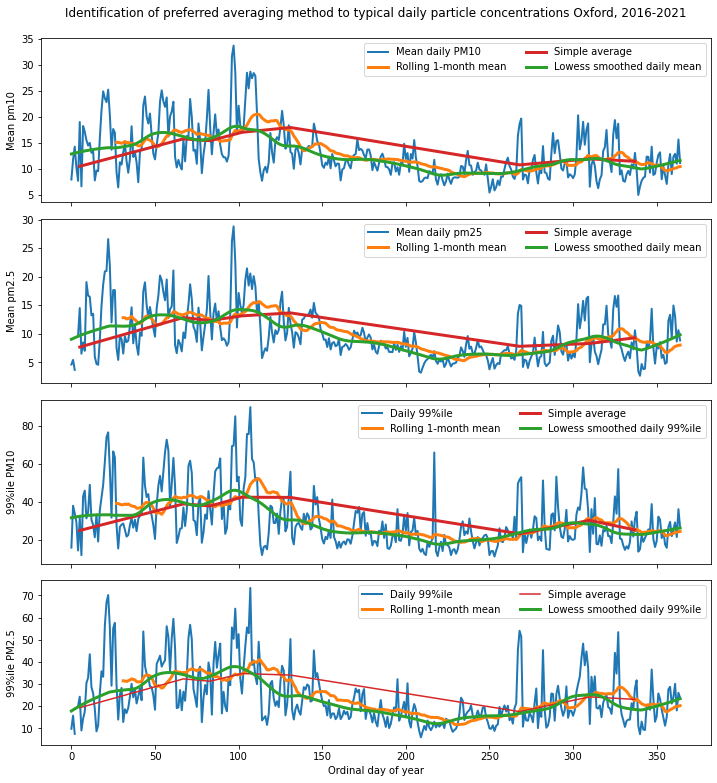

In [17]:
# Compare approaches to calculating mean dailt PM10 values by ordinal day
#-------------------------------------------------------------------------

sebbes_lowess_daymean = pd.DataFrame()

# Doing PM10
#------------
figure, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12,13), sharex=True)

sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm10_mean', ax=ax1, label='Mean daily PM10', lw=2)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28).mean(), x=sebbes_ordinal_daymean.index, y='pm10_mean', ax=ax1, label='Rolling 1-month mean', lw=3, color='tab:orange')
sns.lineplot(data=qq_df, x='ord', y='pm10mean', ax=ax1, label='Simple average', lw=3, markers='o', ls=None, color='tab:red')
smoothed_m2 = pd.DataFrame(sm.nonparametric.lowess(exog=sebbes_ordinal_daymean.index, endog=sebbes_ordinal_daymean['pm10_mean'], frac=0.13, it=1),  columns=['x','y10'])
sns.lineplot(data=smoothed_m2, x='x', y='y10', ax=ax1, label='Lowess smoothed daily mean', lw=3, color='tab:green')

smoothed_m2.rename(columns={'x':'date'},inplace=True)
sm2_af = lockdown_codeup_onordinal_af(smoothed_m2)
sm2_fk = lockdown_codeup_onordinal_fk(smoothed_m2)
sm2_coded = pd.concat([sm2_af,sm2_fk])
tmplist = []
for i, r in sm2_coded.groupby('ld_code'):
    tmp = r.groupby(['ld_code']).describe()
    tmplist.append(tmp)
sm2_coded_desc = pd.concat(tmplist)
sm2_coded_desc = sm2_coded_desc.iloc[:,16:].droplevel(0,axis=1)
sm2_coded_desc['poll'] = 'pm1024h'
sebbes_lowess_daymean = sebbes_lowess_daymean.append(sm2_coded_desc)

# Doing PM2.5
#-------------
sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm25_mean', ax=ax2, label='Mean daily pm25', lw=2)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28).mean(), x=sebbes_ordinal_daymean.index, y='pm25_mean', ax=ax2, label='Rolling 1-month mean', lw=3, color='tab:orange')
sns.lineplot(data=qq_df, x='ord', y='pm25mean', ax=ax2, label='Simple average', lw=3, color='tab:red')
smoothed_m2 = pd.DataFrame(sm.nonparametric.lowess(exog=sebbes_ordinal_daymean.index, endog=sebbes_ordinal_daymean['pm25_mean'], frac=0.13, it=1),  columns=['x','y25'])
sns.lineplot(data=smoothed_m2, x='x', y='y25', ax=ax2, label='Lowess smoothed daily mean', lw=3, color='tab:green')

smoothed_m2.rename(columns={'x':'date'},inplace=True)
sm2_af = lockdown_codeup_onordinal_af(smoothed_m2)
sm2_fk = lockdown_codeup_onordinal_fk(smoothed_m2)
sm2_coded = pd.concat([sm2_af,sm2_fk])
tmplist = []
for i, r in sm2_coded.groupby('ld_code'):
    tmp = r.groupby(['ld_code']).describe()
    tmplist.append(tmp)
sm2_coded_desc = pd.concat(tmplist)
sm2_coded_desc = sm2_coded_desc.iloc[:,16:].droplevel(0,axis=1)
sm2_coded_desc['poll'] = 'pm2524h'
sebbes_lowess_daymean = sebbes_lowess_daymean.append(sm2_coded_desc)

# Doing PM10, 99%ile
#--------------------
sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm10_99%', ax=ax3, label='Daily 99%ile', lw=2)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28).mean(), x=sebbes_ordinal_daymean.index, y='pm10_99%', ax=ax3, label='Rolling 1-month mean', lw=3, color='tab:orange')
sns.lineplot(data=qq_df, x='ord', y='pm10p99_mean', ax=ax3, label='Simple average', lw=3, color='tab:red')
smoothed_m2 = pd.DataFrame(sm.nonparametric.lowess(exog=sebbes_ordinal_daymean.index, endog=sebbes_ordinal_daymean['pm10_99%'], frac=0.13, it=1),  columns=['x','ypm1099'])
sns.lineplot(data=smoothed_m2, x='x', y='ypm1099', ax=ax3, label='Lowess smoothed daily 99%ile', lw=3, color='tab:green')

smoothed_m2.rename(columns={'x':'date'},inplace=True)
sm2_af = lockdown_codeup_onordinal_af(smoothed_m2)
sm2_fk = lockdown_codeup_onordinal_fk(smoothed_m2)
sm2_coded = pd.concat([sm2_af,sm2_fk])
tmplist = []
for i, r in sm2_coded.groupby('ld_code'):
    tmp = r.groupby(['ld_code']).describe()
    tmplist.append(tmp)
sm2_coded_desc = pd.concat(tmplist)
sm2_coded_desc = sm2_coded_desc.iloc[:,16:].droplevel(0,axis=1)
sm2_coded_desc['poll'] = 'pm10p99'
sebbes_lowess_daymean = sebbes_lowess_daymean.append(sm2_coded_desc)


# Doing PM2.5, 99%ile
#---------------------
sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm25_99%', ax=ax4, label='Daily 99%ile', lw=2)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28).mean(), x=sebbes_ordinal_daymean.index, y='pm25_99%', ax=ax4, label='Rolling 1-month mean', lw=3, color='tab:orange')
sns.lineplot(data=qq_df, x='ord', y='pm25p99_mean', ax=ax4, label='Simple average', markers=True, color='tab:red')
smoothed_m2 = pd.DataFrame(sm.nonparametric.lowess(exog=sebbes_ordinal_daymean.index, endog=sebbes_ordinal_daymean['pm25_99%'], frac=0.13, it=1),  columns=['x','ypm2599'])
sns.lineplot(data=smoothed_m2, x='x', y='ypm2599', ax=ax4, label='Lowess smoothed daily 99%ile', lw=3, color='tab:green')

smoothed_m2.rename(columns={'x':'date'},inplace=True)
sm2_af = lockdown_codeup_onordinal_af(smoothed_m2)
sm2_fk = lockdown_codeup_onordinal_fk(smoothed_m2)
sm2_coded = pd.concat([sm2_af,sm2_fk])
tmplist = []
for i, r in sm2_coded.groupby('ld_code'):
    tmp = r.groupby(['ld_code']).describe()
    tmplist.append(tmp)
sm2_coded_desc = pd.concat(tmplist)
sm2_coded_desc = sm2_coded_desc.iloc[:,16:].droplevel(0,axis=1)
sm2_coded_desc['poll'] = 'pm25p99'
sebbes_lowess_daymean = sebbes_lowess_daymean.append(sm2_coded_desc)


ax1.set(xlabel='', ylabel = 'Mean pm10', title='Identification of preferred averaging method to typical daily particle concentrations Oxford, 2016-2021\n')
ax2.set(ylabel = 'Mean pm2.5')
ax3.set(ylabel = '99%ile PM10')
ax4.set(xlabel='Ordinal day of year', ylabel = '99%ile PM2.5')

ax1.legend(ncol=2, loc='upper right')
ax2.legend(ncol=2, loc='upper right')
ax3.legend(ncol=2, loc='upper right')
ax4.legend(ncol=2, loc='upper right')
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.savefig(stats_home+'identifying_averging_methods.png')

plt.show()

sebbes_lowess_daymean.reset_index().to_feather(stats_home+'sebbes_lowess_daymean.ftr')


In [18]:
# # Calc the descriptive stats for sebbes by lockdown period
# # ----------------------------------------------------------

# display(sebbes_ordinal_daymean_codeup_af['ld_code'].unique())
# display(sebbes_ordinal_daymean_codeup_fk['ld_code'].unique())

# # pm10 arithemtic mean, events 'a' to 'k'
# tmplist = []
# for i, r in sebbes_ordinal_daymean_codeup_af.groupby('ld_code'):
#     tmp = r.groupby(['ld_code'])[['pm10_mean']].describe(
#         percentiles=[.99])
#     tmplist.append(tmp)
# sebbes_ordinal_daymean_codeup_af_mean = pd.concat(tmplist)
# sebbes_ordinal_daymean_codeup_af_mean['poll'] = 'pm10'

# # pm10 lowess best fit, events 'a' to 'k'
# tmplist = []
# for i, r in sebbes_ordinal_daymean_codeup_af.groupby('ld_code'):
#     tmp = r.groupby(['ld_code'])[['y10']].describe(
#         percentiles=[.99])
#     tmplist.append(tmp)
# sebbes_ordinal_daymean_codeup_af_y10 = pd.concat(tmplist)
# sebbes_ordinal_daymean_codeup_af_y10['poll'] = 'pm10'

# # pm10 lowess best fit, events 'a' to 'k'
# tmplist = []
# for i, r in sebbes_ordinal_daymean_codeup_af.groupby('ld_code'):
#     tmp = r.groupby(['ld_code'])[['ypm1099']].describe(
#         percentiles=[.99])
#     tmplist.append(tmp)
# sebbes_ordinal_daymean_codeup_af_ypm1099 = pd.concat(tmplist)
# sebbes_ordinal_daymean_codeup_af_ypm1099['poll'] = 'pm10'

# # pm10 arithemtic mean, events 'l' to 'r'
# tmplist = []
# for i, r in sebbes_ordinal_daymean_codeup_fk.groupby('ld_code'):
#     tmp = r.groupby(['ld_code'])[['pm10_mean']].describe(
#         percentiles=[.99])
#     tmplist.append(tmp)
# sebbes_ordinal_daymean_codeup_fk_mean = pd.concat(tmplist)
# sebbes_ordinal_daymean_codeup_fk_mean['poll'] = 'pm10'

# # pm10 lowess best fit, events 'l' to 'r'
# tmplist = []
# for i, r in sebbes_ordinal_daymean_codeup_fk.groupby('ld_code'):
#     tmp = r.groupby(['ld_code'])[['y10']].describe(
#         percentiles=[.99])
#     tmplist.append(tmp)
# sebbes_ordinal_daymean_codeup_fk_y10 = pd.concat(tmplist)
# sebbes_ordinal_daymean_codeup_fk_y10['poll'] = 'pm10'

# # pm10 lowess best fit, events 'l' to 'r'
# tmplist = []
# for i, r in sebbes_ordinal_daymean_codeup_fk.groupby('ld_code'):
#     tmp = r.groupby(['ld_code'])[['ypm1099']].describe(
#         percentiles=[.99])
#     tmplist.append(tmp)
# sebbes_ordinal_daymean_codeup_fk_ypm1099 = pd.concat(tmplist)
# sebbes_ordinal_daymean_codeup_fk_ypm1099['poll'] = 'pm10'

# sebbes_pm10_ld_event_desc_mean = pd.concat([sebbes_ordinal_daymean_codeup_af_mean,
#                                             sebbes_ordinal_daymean_codeup_fk_mean
#                                             ])
# sebbes_pm10_ld_event_desc_ymean = pd.concat([sebbes_ordinal_daymean_codeup_af_y10,
#                                            sebbes_ordinal_daymean_codeup_fk_y10
#                                            ])
# sebbes_pm10_ld_event_desc_y99 = pd.concat([sebbes_ordinal_daymean_codeup_af_ypm1099,
#                                            sebbes_ordinal_daymean_codeup_fk_ypm1099
#                                            ])

# s1 = sebbes_pm10_ld_event_desc_mean.iloc[:,[0,1,2,3,4,5,6]].add_prefix('pm10_').columns.droplevel().tolist()
# s1.append('poll')
# sebbes_pm10_ld_event_desc_mean.columns = s1
# s2 = sebbes_pm10_ld_event_desc_ymean.iloc[:,[0,1,2,3,4,5,6]].add_prefix('pm10y_').columns.droplevel().tolist()
# s2.append('poll')
# sebbes_pm10_ld_event_desc_ymean.columns = s2
# s3 = sebbes_pm10_ld_event_desc_y99.iloc[:,[0,1,2,3,4,5,6]].add_prefix('pm10y99_').columns.droplevel().tolist()
# s3.append('poll')
# sebbes_pm10_ld_event_desc_y99.columns = s3

# sebbes_pm10_ld_event_desc_mean.reset_index().to_feather(stats_home+'sebbes_pm10_ld_event_desc_mean.ftr')
# sebbes_pm10_ld_event_desc_ymean.reset_index().to_feather(stats_home+'sebbes_pm10_ld_event_desc_ymean.ftr')
# sebbes_pm10_ld_event_desc_y99.reset_index().to_feather(stats_home+'sebbes_pm10_ld_event_desc_y99.ftr')

# display(sebbes_pm10_ld_event_desc_mean, sebbes_pm10_ld_event_desc_ymean, sebbes_pm10_ld_event_desc_y99)

In [19]:
# # Calc the descriptive stats for sebbes by lockdown period
# # ----------------------------------------------------------

# display(sebbes_ordinal_daymean_codeup_af['ld_code'].unique())
# display(sebbes_ordinal_daymean_codeup_fk['ld_code'].unique())

# # pm25 arithemtic mean, events 'a' to 'k'
# tmplist = []
# for i, r in sebbes_ordinal_daymean_codeup_ar.groupby('ld_code'):
#     tmp = r.groupby(['ld_code'])[['pm25_mean']].describe(
#         percentiles=[.99])
#     tmplist.append(tmp)
# sebbes_ordinal_daymean_codeup_ar_mean = pd.concat(tmplist)
# sebbes_ordinal_daymean_codeup_ar_mean['poll'] = 'pm25'

# # pm25 lowess best fit, events 'a' to 'k'
# tmplist = []
# for i, r in sebbes_ordinal_daymean_codeup_ar.groupby('ld_code'):
#     tmp = r.groupby(['ld_code'])[['y25']].describe(
#         percentiles=[.99])
#     tmplist.append(tmp)
# sebbes_ordinal_daymean_codeup_ar_y10 = pd.concat(tmplist)
# sebbes_ordinal_daymean_codeup_ar_y10['poll'] = 'pm25'

# # pm25 lowess best fit, events 'a' to 'k'
# tmplist = []
# for i, r in sebbes_ordinal_daymean_codeup_ar.groupby('ld_code'):
#     tmp = r.groupby(['ld_code'])[['ypm2599']].describe(
#         percentiles=[.99])
#     tmplist.append(tmp)
# sebbes_ordinal_daymean_codeup_ar_ypm2599 = pd.concat(tmplist)
# sebbes_ordinal_daymean_codeup_ar_ypm2599['poll'] = 'pm25'

# # pm25 arithemtic mean, events 'l' to 'r'
# tmplist = []
# for i, r in sebbes_ordinal_daymean_codeup_fk.groupby('ld_code'):
#     tmp = r.groupby(['ld_code'])[['pm25_mean']].describe(
#         percentiles=[.99])
#     tmplist.append(tmp)
# sebbes_ordinal_daymean_codeup_fk_mean = pd.concat(tmplist)
# sebbes_ordinal_daymean_codeup_fk_mean['poll'] = 'pm25'

# # pm25 lowess best fit, events 'l' to 'r'
# tmplist = []
# for i, r in sebbes_ordinal_daymean_codeup_fk.groupby('ld_code'):
#     tmp = r.groupby(['ld_code'])[['y25']].describe(
#         percentiles=[.99])
#     tmplist.append(tmp)
# sebbes_ordinal_daymean_codeup_fk_y10 = pd.concat(tmplist)
# sebbes_ordinal_daymean_codeup_fk_y10['poll'] = 'pm25'

# # pm25 lowess best fit, events 'l' to 'r'
# tmplist = []
# for i, r in sebbes_ordinal_daymean_codeup_fk.groupby('ld_code'):
#     tmp = r.groupby(['ld_code'])[['ypm2599']].describe(
#         percentiles=[.99])
#     tmplist.append(tmp)
# sebbes_ordinal_daymean_codeup_fk_ypm2599 = pd.concat(tmplist)
# sebbes_ordinal_daymean_codeup_fk_ypm2599['poll'] = 'pm25'

# sebbes_pm25_ld_event_desc_mean = pd.concat([sebbes_ordinal_daymean_codeup_ar_mean,
#                                             sebbes_ordinal_daymean_codeup_fk_mean
#                                             ])
# sebbes_pm25_ld_event_desc_ymean = pd.concat([sebbes_ordinal_daymean_codeup_ar_y10,
#                                            sebbes_ordinal_daymean_codeup_fk_y10
#                                            ])
# sebbes_pm25_ld_event_desc_y99 = pd.concat([sebbes_ordinal_daymean_codeup_ar_ypm2599,
#                                            sebbes_ordinal_daymean_codeup_fk_ypm2599
#                                            ])

# s1 = sebbes_pm25_ld_event_desc_mean.iloc[:,[0,1,2,3,4,5,6]].add_prefix('pm25_').columns.droplevel().tolist()
# s1.append('poll')
# sebbes_pm25_ld_event_desc_mean.columns = s1
# s2 = sebbes_pm25_ld_event_desc_ymean.iloc[:,[0,1,2,3,4,5,6]].add_prefix('pm25y_').columns.droplevel().tolist()
# s2.append('poll')
# sebbes_pm25_ld_event_desc_ymean.columns = s2
# s3 = sebbes_pm25_ld_event_desc_y99.iloc[:,[0,1,2,3,4,5,6]].add_prefix('pm25y99_').columns.droplevel().tolist()
# s3.append('poll')
# sebbes_pm25_ld_event_desc_y99.columns = s3

# sebbes_pm25_ld_event_desc_mean.reset_index().to_feather(stats_home+'sebbes_pm25_ld_event_desc_mean.ftr')
# sebbes_pm25_ld_event_desc_ymean.reset_index().to_feather(stats_home+'sebbes_pm25_ld_event_desc_ymean.ftr')
# sebbes_pm25_ld_event_desc_y99.reset_index().to_feather(stats_home+'sebbes_pm25_ld_event_desc_y99.ftr')

# display(sebbes_pm25_ld_event_desc_mean, sebbes_pm25_ld_event_desc_ymean, sebbes_pm25_ld_event_desc_y99)